# Data Analysis Indoor Location at University of Jaime I.
----------------------

## Library Importation

In [1]:
import sys
sys.path.append("./lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib.Methods import GeneralMethods
from lib.edasSearch import EdasHyperparameterSearch
from lib.Hiperparametros import HyperparameterSwitcher
from lib.ImportacionModelos import getClassifierNames
from lib.ImportacionModelos import getClassifierModels
from lib.ImportacionModelos import getRegressorNames
from lib.ImportacionModelos import getRegressorModels
from lib.graphicGenerator import GraphicBuilder

description = pd.read_csv("data/description.csv", sep=";")
dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")
dfFull = dfTrain.append(dfTest, ignore_index=True)
gbFull = GraphicBuilder(dfFull)
# Setting new data type
dfFull.FLOOR = dfFull.FLOOR.apply(str)
dfFull.BUILDINGID = dfFull.BUILDINGID.apply(str)
dfFull.SPACEID = dfFull.SPACEID.apply(str)
dfFull.RELATIVEPOSITION = dfFull.RELATIVEPOSITION.apply(str)
dfFull.USERID = dfFull.USERID.apply(str)
dfFull.PHONEID = dfFull.PHONEID.apply(str)

## Exploratory Analysis

In [2]:
display(description)
display(str(dfTrain.shape[1]) + ' features')
display('Train Shape: ' + str(dfTrain.shape[0]) + ' observations')
display('Test Shape:  ' + str(dfTest.shape[0]) + ' observations')

,Attribute,Definition
WAP001,Intensity value for WAP001,Negative integer values from -104 to 0 and +1...
...,...,...
WAP520,Intensity value for WAP520,Negative integer values from -104 to 0 and +1...
Longitude,Longitude,Negative real values from -7695.9387549299299...
Latitude,Latitude,Positive real values from 4864745.7450159714 ...
Floor,Altitude in floors inside the building,Integer values from 0 to 4.
BuildingID,ID to identify the building. Measures were ta...,Categorical integer values from 0 to 2.
SpaceID,Internal ID number to identify the Space (off...,Categorical integer values.
RelativePosition,Relative position with respect to the Space (...,Categorical integer values.
UserID,User identifier,Categorical integer values.


'529 features'

'Train Shape: 19937 observations'

'Test Shape:  1111 observations'

In [3]:
# Colums Data Description
display('Numerical Data')
display(dfFull[dfFull.columns.values[519:]].describe(include=['int64', 'float']))
display('Categorital Data')
display(dfFull[dfFull.columns.values[519:]].describe(include=['object']))

'Numerical Data'

,WAP520,LONGITUDE,LATITUDE,TIMESTAMP
count,21048.000000,21048.000000,2.104800e+04,2.104800e+04
mean,99.991733,-7467.702771,4.864873e+06,1.371906e+09
std,1.199344,124.084870,6.746981e+01,2.126924e+06
min,-74.000000,-7695.938755,4.864746e+06,1.369909e+09
25%,100.000000,-7601.616200,4.864821e+06,1.371709e+09
50%,100.000000,-7425.661100,4.864854e+06,1.371716e+09
75%,100.000000,-7359.331100,4.864930e+06,1.371721e+09
max,100.000000,-7299.786517,4.865017e+06,1.381248e+09


'Categorital Data'

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,21048,21048,21048,21048,21048,21048
unique,5,3,124,3,19,25
top,1,2,0,2,11,13
freq,5464,9760,1111,16608,4516,4885


FLOOR,0,1,2,3,4
BUILDINGID,,,,,
0,1137,1564,1608,1476,0
1,1398,1627,1483,995,0
2,1966,2273,1631,2749,1141


<IPython.core.display.Javascript object>


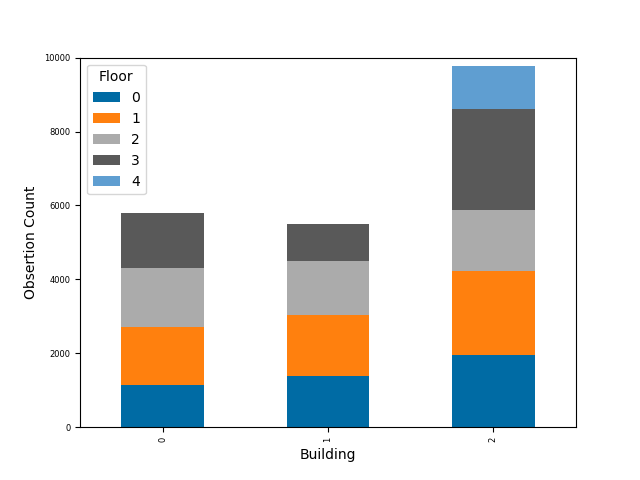

In [4]:
%matplotlib notebook
fullct = pd.crosstab(dfFull.BUILDINGID, dfFull.FLOOR)
display(fullct)
ax = fullct.plot.bar(stacked=True)
ax.set_xlabel("Building")
ax.set_ylabel("Obsertion Count")
ax.set_ylim(0, 10000)
plt.legend(title='Floor')
plt.show()

<IPython.core.display.Javascript object>


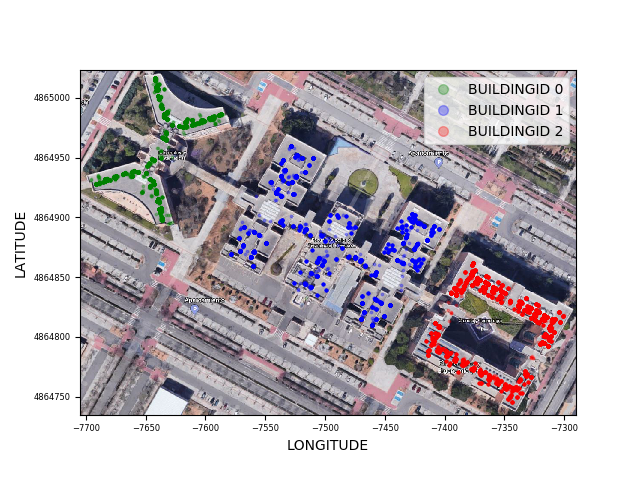

In [5]:
gbFull.graphicMap2D(filename="buildingsMap2d", x="LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


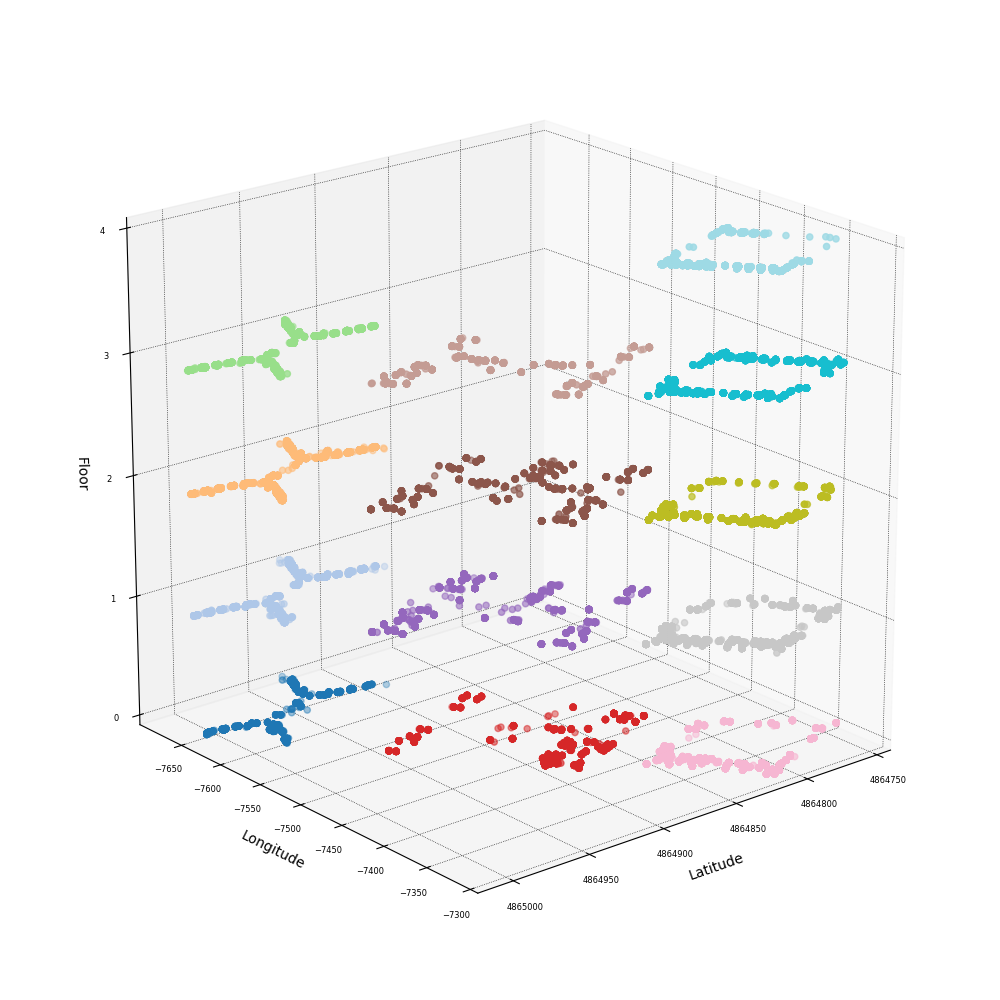

In [6]:
gbFull.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## Data Cleaning and Feature Engineering

$WAP\in (-104,0)$, $WAP=100$ when WAP is not detected. 

Infering that $WAP \in [-120,0]$ and set $WAP=-120$ when is not detected

Parsing WAP to range $[0,1]$ where 0 is not detected and 1 is ideal signal

Having $-120<=WAP<=0$, set rssi transformation to  $0<=\frac{WAP+120}{120}<=1$

### Dealing with missing data

In [7]:
wifiSens = 520
rssiLimit = 120
wifiColumns = dfFull.columns.values[:wifiSens]
outColumns = dfFull.columns.values[wifiSens:]
x_data = dfFull[wifiColumns]
x_data.replace([100],[-rssiLimit], inplace=True)
x_data = x_data.apply(lambda x: (x+rssiLimit)/rssiLimit, axis=1)
ndwapDf = list(map(lambda wapName: pd.DataFrame(list(map(lambda x: {'ND_' + wapName:x==0}, x_data[wapName]))), wifiColumns))
dfFiltered = pd.concat([x_data] + ndwapDf, axis=1)
dfFiltered[dfFiltered.columns.values[wifiSens:]] = dfFiltered[dfFiltered.columns.values[wifiSens:]].astype(int)
dfFiltered['ND_WAP_COUNT'] = dfFiltered[dfFiltered.columns.values[wifiSens:]].sum(axis=1) # wap no detecteds
dfClean = pd.concat([dfFiltered, dfFull[outColumns]], axis=1)

### Dealing with unwanted observations

__Duplicated Data:__ Drop all rows whose column values are the same, conserve first apparition

In [8]:
dfClean[dfClean.duplicated(dfClean.columns.values, keep='first')].shape

(637, 1050)

In [9]:
display('Initial Size:' + str(dfClean.shape))
dfClean.drop_duplicates(dfClean.columns.values, keep='first', inplace=True)
dfClean.reset_index(drop=True, inplace=True)
display('Final Size:' + str(dfClean.shape))

'Initial Size:(21048, 1050)'

'Final Size:(20411, 1050)'

__Irrelevant observations:__ Two study cases that could reduce the consistency of the data

__Case 1:__ What happen if all wap are not detected?

In [10]:
dfWap = dfClean[wifiColumns]
dfNoDetectedWap = dfClean[dfClean.ND_WAP_COUNT == wifiSens] #suma de columnas
gbNDWap = GraphicBuilder(dfNoDetectedWap)
dfNoDetectedWap.shape

(73, 1050)

FLOOR,0,1,2,3
BUILDINGID,,,,
0,1,0,0,0
1,0,0,0,34
2,36,1,1,0


<IPython.core.display.Javascript object>


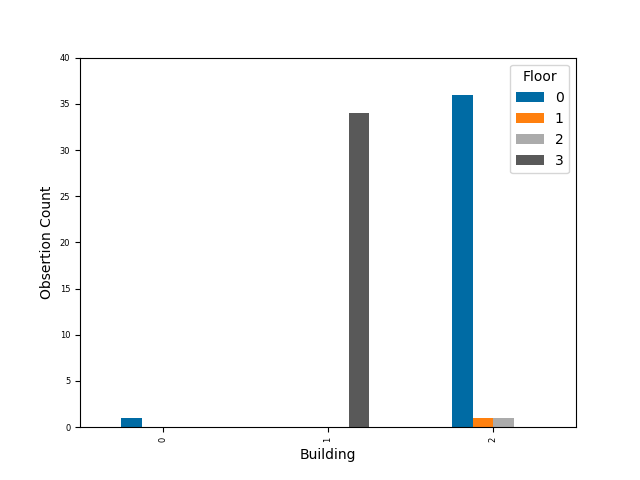

In [11]:
fullct1 = pd.crosstab(dfNoDetectedWap.BUILDINGID, dfNoDetectedWap.FLOOR)
display(fullct1)
#"""
ax = fullct1.plot.bar(stacked=False)
ax.set_xlabel("Building")
ax.set_ylabel("Obsertion Count")
ax.set_ylim(0, 40)
plt.legend(title='Floor')
plt.show()
#"""
#gbNDWap.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3dNotDetected")

_These data would be relevant if we had at least one signal that made us distinguish between buildings, or if we work the buildings separately. But as it is not the case these data only generate inconsistency and randomness._

In [12]:
display('Initial Size:' + str(dfClean.shape))
dfClean = dfClean[dfClean.ND_WAP_COUNT != wifiSens]
dfClean.reset_index(drop=True, inplace=True)
display('Final Size:' + str(dfClean.shape))

'Initial Size:(20411, 1050)'

'Final Size:(20338, 1050)'

__Case 2:__ What happen if for some wap is never detected?

In [13]:
display('Max observations with not detected wap: ' + str(np.max(dfClean[dfClean.columns.values[wifiSens:2*wifiSens]].sum(axis=0))))
display('Max observations: ' + str(dfClean.shape[0]))

'Max observations with not detected wap: 20337'

'Max observations: 20338'

_Case 2 is not happening in CleanData_

In [22]:
# Saving Filtred Data
dfClean[dfClean.columns[:2*wifiSens+5]].to_csv("data/filtred.csv", index=False)

## Dealing with PhoneId

In [37]:
dfClean.PHONEID.value_counts()

13    4885
14    4863
7     1596
6     1383
23    1091
19     980
8      913
17     841
22     724
3      610
1      507
11     498
10     440
24     437
18     374
20     213
16     192
0      120
9       77
12      70
4       69
21      60
2       52
15      36
5       17
Name: PHONEID, dtype: int64

In [ ]:
dfClean['PHONEID2'] = dfClean.PHONEID.replace(
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
    ['Other', 'GT', 'GT', 'GT', 'GT', 'GT', 'GT', 'GT', 'Galaxy', 'Galaxy', 'HTC', 'HTC', 'HTC', 'HTC', 'LT2i', 'LT2i', 'LT2i', 'Other', 'Other', 'Nexus', 'Nexus', 'Nexus', 'Other', 'Other', 'Other']
)
for bid in ['0', '1', '2']:
    display('Building '+bid)
    display(pd.crosstab(dfClean[dfClean.BUILDINGID==bid].PHONEID2, dfClean[dfClean.BUILDINGID==bid].FLOOR))

__Testing Classifier score__

In [17]:
scoreFloor = cross_validate(modelClassifier, X_train, y_train.FLOOR, scoring=scoring_acc, cv=kf, return_train_score=False)
scoreBuilding = cross_validate(modelClassifier, X_train, y_train.BUILDINGID, scoring=scoring_acc, cv=kf, return_train_score=False)

In [18]:
print('Building Prediction Score')
print('NbAccuracy: ' +str(scoreBuilding['test_nbaccuracy'].mean()) + ' +/- ' + str(scoreBuilding['test_nbaccuracy'].std()))
print('Accuracy: ' +str(scoreBuilding['test_accuracy'].mean()) + ' +/- ' + str(scoreBuilding['test_accuracy'].std()))
print('\nFloor Prediction Score')
print('NbAccuracy: ' +str(scoreFloor['test_nbaccuracy'].mean()) + ' +/- ' + str(scoreFloor['test_nbaccuracy'].std()))
print('Accuracy: ' +str(scoreFloor['test_accuracy'].mean()) + ' +/- ' + str(scoreFloor['test_accuracy'].std()))

Building Prediction Score
NbAccuracy: 0.9998458561891397 +/- 0.0003093945169366835
Accuracy: 0.9998770743700062 +/- 0.00024585125998770606

Floor Prediction Score
NbAccuracy: 0.990477678554685 +/- 0.0018242809508414676
Accuracy: 0.9886293792255685 +/- 0.0020615254863243547


__Testing Regression score__

In [19]:
scoreLatitude = cross_validate(modelRegressor, X_train, y_train.LATITUDE, scoring=scoring_reg, cv=kf, return_train_score=False)
scoreLongitude = cross_validate(modelRegressor, X_train, y_train.LONGITUDE, scoring=scoring_reg, cv=kf, return_train_score=False)

In [20]:
print('Latitude Prediction Score')
print('Distance: ' +str(scoreLatitude['test_distance'].mean()) + ' +/- ' + str(scoreLatitude['test_distance'].std()))
print('MAE: ' +str(scoreLatitude['test_mae'].mean()) + ' +/- ' + str(scoreLatitude['test_mae'].std()))
print('MSE: ' +str(scoreLatitude['test_mse'].mean()) + ' +/- ' + str(scoreLatitude['test_mse'].std()))
print('r2: ' +str(scoreLatitude['test_r2'].mean()) + ' +/- ' + str(scoreLatitude['test_r2'].std()))
print('\nLongitude Prediction Score')
print('Distance: ' +str(scoreLongitude['test_distance'].mean()) + ' +/- ' + str(scoreLongitude['test_distance'].std()))
print('MAE: ' +str(scoreLongitude['test_mae'].mean()) + ' +/- ' + str(scoreLongitude['test_mae'].std()))
print('MSE: ' +str(scoreLongitude['test_mse'].mean()) + ' +/- ' + str(scoreLongitude['test_mse'].std()))
print('r2: ' +str(scoreLongitude['test_r2'].mean()) + ' +/- ' + str(scoreLongitude['test_r2'].std()))

Latitude Prediction Score
Distance: 2.0209468804079913 +/- 0.09028632321851827
MAE: 2.496909781268923 +/- 0.11154940832748315
MSE: 23.023620265484464 +/- 3.0988553370087306
r2: 0.9949990007518197 +/- 0.0006973908486174134

Longitude Prediction Score
Distance: 3.0844218455093264 +/- 0.09141988670096816
MAE: 3.0233079835978716 +/- 0.08960851889590186
MSE: 37.860556036202965 +/- 6.007959933243212
r2: 0.9975644650801835 +/- 0.0003903373829084829


## 6. Model Comparison

## 7. Evaluation Result & Error

In [21]:
modelClassifier = RandomForestClassifier(n_jobs=-1, random_state=seed)
modelClassifier.fit(X_train, y_train.FLOOR)
p_floor = modelClassifier.predict(X_test)

modelClassifier = RandomForestClassifier(n_jobs=-1, random_state=seed)
modelClassifier.fit(X_train, y_train.BUILDINGID)
p_building = modelClassifier.predict(X_test)

modelRegressor = RandomForestRegressor(n_jobs=-1, random_state=seed)
modelRegressor.fit(X_train, y_train.LATITUDE)
p_latitude = modelRegressor.predict(X_test)

modelRegressor = RandomForestRegressor(n_jobs=-1, random_state=seed)
modelRegressor.fit(X_train, y_train.LONGITUDE)
p_longitude = modelRegressor.predict(X_test)

# setting predicted values into dataframe
y_pred = pd.DataFrame()
y_pred['PRED_FLOOR'] = p_floor
y_pred['PRED_BUILDINGID'] = p_building
y_pred['PRED_LATITUDE'] = p_latitude
y_pred['PRED_LONGITUDE'] = p_longitude

dfValidation = pd.concat([pd.concat([X_test,y_test], axis=1).reset_index(drop=True), y_pred], axis=1)
gbTest.updateDataFrame(dfValidation)
gbTest.convertInt()

<IPython.core.display.Javascript object>


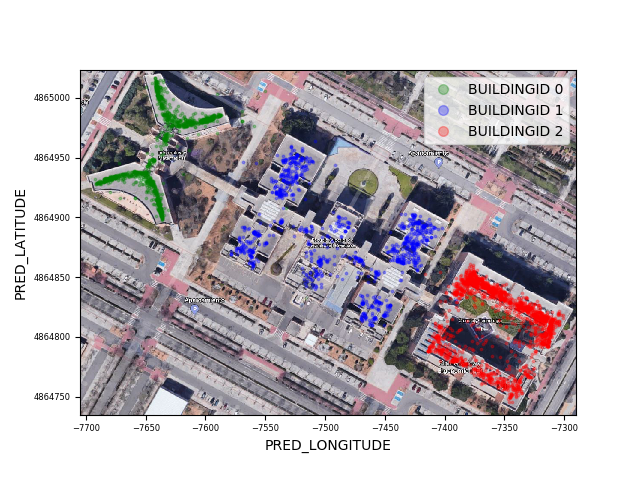

In [22]:
gbTest.graphicMap2D(filename="predictedMap2d", x="PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


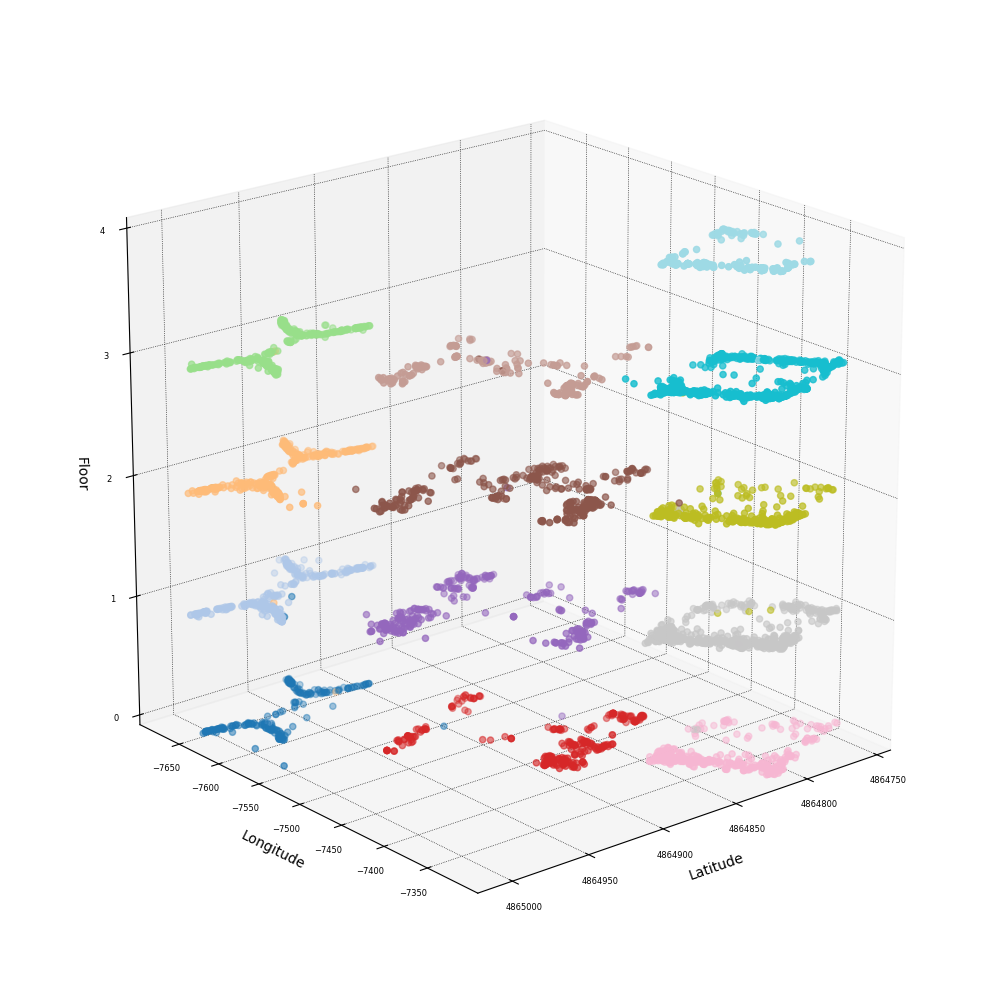

In [23]:
gbTest.graphicMap3D(columns = ["PRED_LATITUDE", "PRED_LONGITUDE", "PRED_FLOOR"], filename="predictedBuildingsMap3d")

In [24]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Graphics
## https://seaborn.pydata.org/examples/kde_ridgeplot.html
## https://seaborn.pydata.org/examples/wide_data_lineplot.html
## https://seaborn.pydata.org/examples/scatter_bubbles.html
# Model Evaluation & quality prediction
## http://scikit-learn.org/stable/modules/model_evaluation.html
## http://scikit-learn.org/stable/modules/model_evaluation.html

<IPython.core.display.Javascript object>


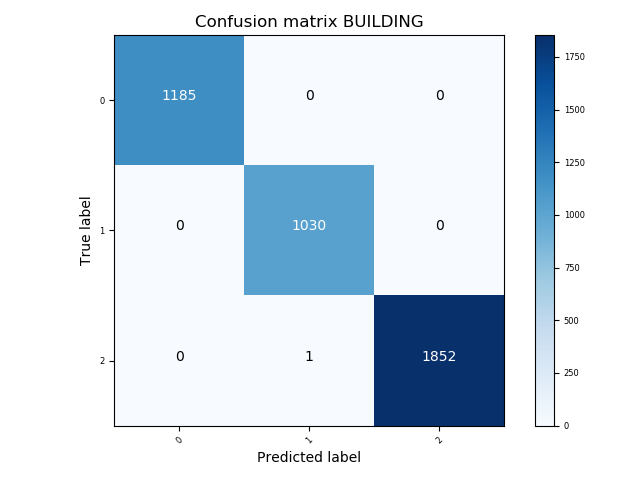

In [25]:
plot_confusion_matrix(scoreMetrics.confusion_matrix(y_test.BUILDINGID, p_building), classes=[0,1,2], title='Confusion matrix BUILDING')

<IPython.core.display.Javascript object>


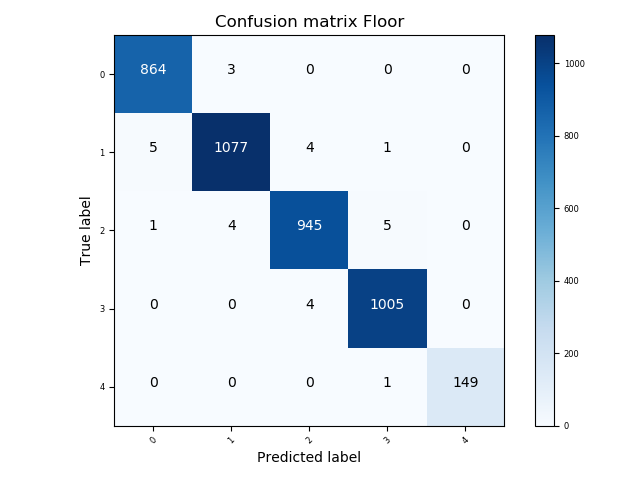

In [26]:
plot_confusion_matrix(scoreMetrics.confusion_matrix(y_test.FLOOR, p_floor), classes=[0,1,2,3,4], title='Confusion matrix Floor')

In [108]:
#sns.set(style="ticks", rc={"lines.linewidth": 0.5, "xtick.color": '0.0'})
#gf = sns.lmplot(x="LATITUDE", y="PRED_LATITUDE", data=dfValidation, x_estimator=np.mean)
#g = sns.factorplot(x="LONGITUDE", y="PRED_LONGITUDE", data=dfValidation)
#gf.axes.x set_xticks(np.linspace(-7500, -7200,10))

<IPython.core.display.Javascript object>


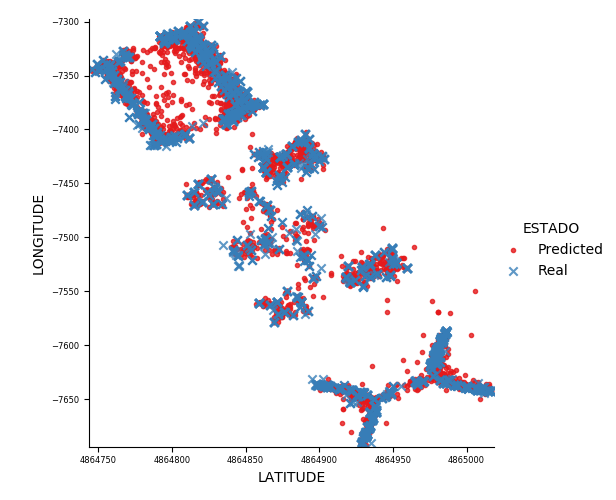

In [28]:
ytemp1 = y_pred[['PRED_LONGITUDE', 'PRED_LATITUDE','PRED_FLOOR', 'PRED_BUILDINGID']].copy()
ytemp1.columns = ['LONGITUDE', 'LATITUDE','FLOOR', 'BUILDINGID']
ytemp2 = y_test.copy()
ytemp1['ESTADO'] = 'Predicted'
ytemp2['ESTADO'] = 'Real'
dfOutput = pd.concat([ytemp1,ytemp2], axis=0)
sns.lmplot(x="LATITUDE", y="LONGITUDE", hue="ESTADO", data=dfOutput, markers=[".", "x"], palette="Set1", fit_reg=False)

<IPython.core.display.Javascript object>


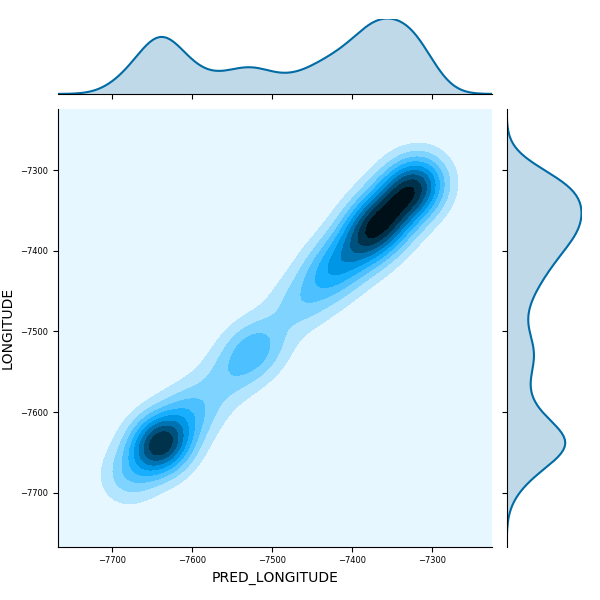

In [29]:
sns.jointplot(dfValidation.PRED_LONGITUDE, dfValidation.LONGITUDE, kind="kde")

<IPython.core.display.Javascript object>


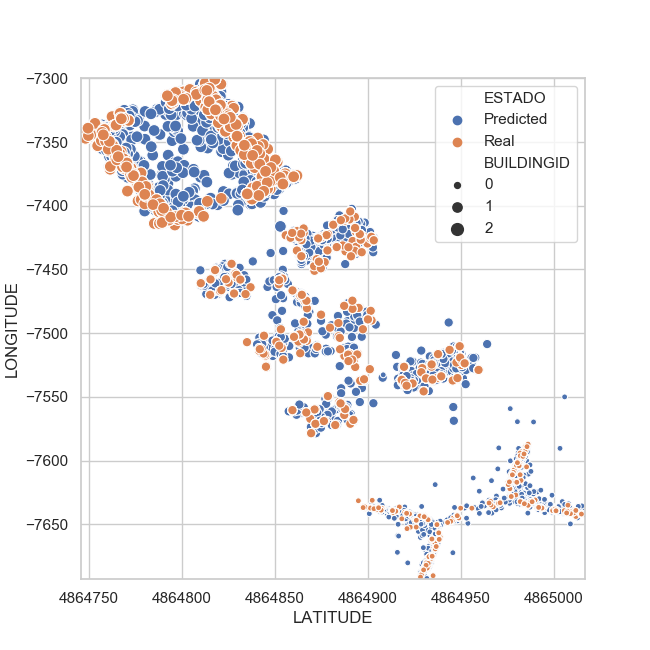

In [90]:
#sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6.5, 6.5))
#sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["Real", "Predicted"]
dfOutput.FLOOR = dfOutput.FLOOR.apply(int)
dfOutput.BUILDINGID = dfOutput.BUILDINGID.apply(int)
sns.scatterplot(x="LATITUDE", y="LONGITUDE", hue="ESTADO", size="BUILDINGID",data=dfOutput)
#linewidth=0,
#palette="ch:r=-.2,d=.3_r",sizes=(1, 8), ax=ax, hue_order=clarity_ranking,
                

<IPython.core.display.Javascript object>


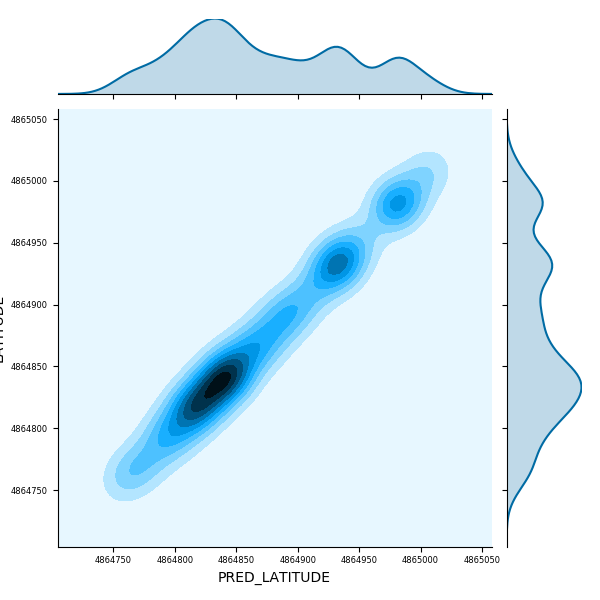

In [30]:
sns.jointplot(dfValidation.PRED_LATITUDE, dfValidation.LATITUDE, kind="kde")

In [31]:
def latitudeListDistance(y_true, y_pred):
    return list(map(lambda yt,yp : geopy.distance.vincenty((_meanLon, yt),(_meanLon, yp)).m , latitudeToGPS(y_true), latitudeToGPS(y_pred)))

def longitudeListDistance(y_true, y_pred):
    return list(map(lambda yt,yp : geopy.distance.vincenty((yt, _meanLat),(yp, _meanLat)).m , longitudeToGPS(y_true), longitudeToGPS(y_pred)))

dlatm = latitudeListDistance(dfValidation.LATITUDE, dfValidation.PRED_LATITUDE)
dlonm = longitudeListDistance(dfValidation.LONGITUDE, dfValidation.PRED_LONGITUDE)

<IPython.core.display.Javascript object>


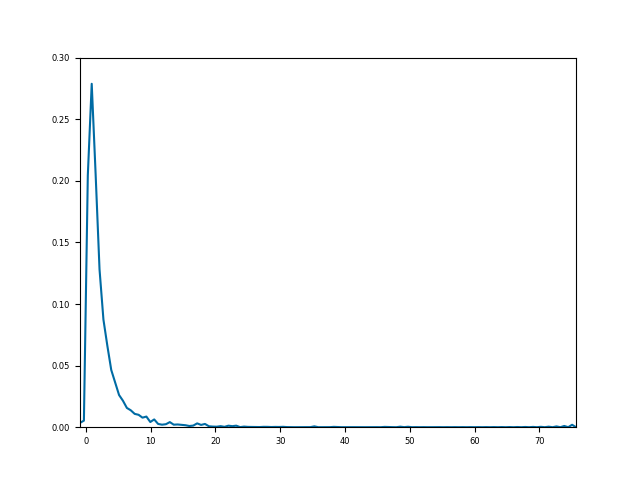

(0, 0.3)

In [80]:
gf = sns.distplot(np.array(dlatm), rug=False, hist=False)
gf.axes.set_ylim(0, 0.3)

In [33]:
dfTemp1 = dfValidation[['BUILDINGID', 'FLOOR']].copy()
dfTemp1['ERROR'] = dlatm
dfTemp1['TYPE'] = 'Latitude'
dfTemp2 = dfValidation[['BUILDINGID', 'FLOOR']].copy()
dfTemp2['ERROR'] = dlonm
dfTemp2['TYPE'] = 'Longitude'
dfCatPlot = pd.concat([dfTemp1,dfTemp2], axis=0)

<IPython.core.display.Javascript object>


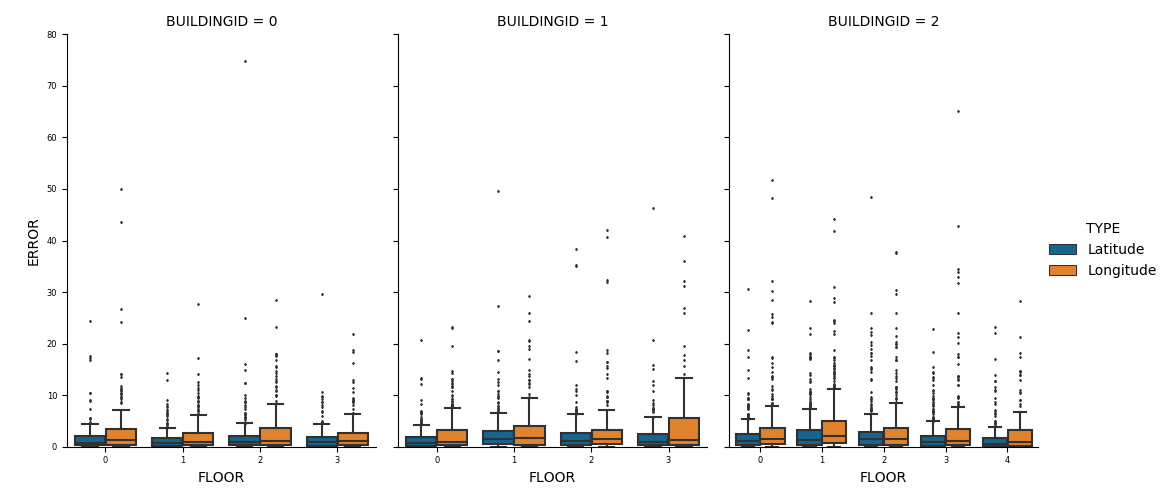

(-0.5, 3.5)

In [70]:
gf = sns.catplot(x="FLOOR", y="ERROR", hue="TYPE", col="BUILDINGID", data=dfCatPlot, kind="box", aspect=.7, fliersize=1.0, linewidth=1.5, sharex=False)
gf.axes[0,0].set_ylim(0, 80)
gf.axes[0,0].set_xticks([0,1,2,3])
gf.axes[0,0].set_xlim(-0.5, 3.5)
gf.axes[0,1].set_xticks([0,1,2,3])
gf.axes[0,1].set_xlim(-0.5, 3.5)
## https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot

<IPython.core.display.Javascript object>


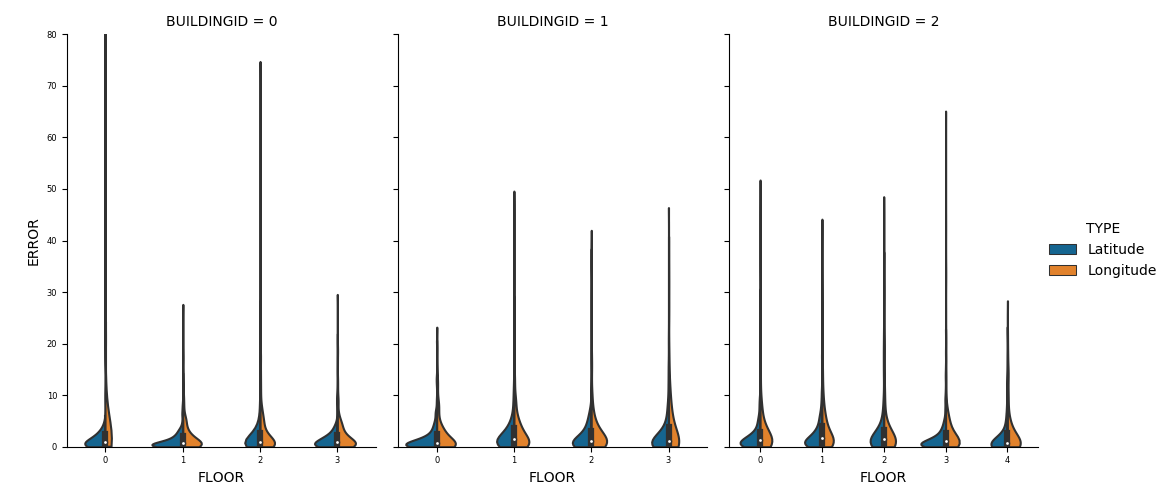

(-0.5, 3.5)

In [72]:
gf = sns.catplot(x="FLOOR", y="ERROR", hue="TYPE", col="BUILDINGID", data=dfCatPlot, kind="violin", split=True, aspect=.7, scale_hue=False, cut=0, sharex=False)
gf.axes[0,0].set_ylim(0, 80)
gf.axes[0,0].set_xticks([0,1,2,3])
gf.axes[0,0].set_xlim(-0.5, 3.5)
gf.axes[0,1].set_xticks([0,1,2,3])
gf.axes[0,1].set_xlim(-0.5, 3.5)